In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import math
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from glob import glob
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
HEIGHT = WIDTH = 512    # HEIGHT and WIDTH were changed to 300 during training of EfficientNetB3
BATCH_SIZE = 64
EPOCHS = 20
TRAIN_PROP = 0.9
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
df_test = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")

In [4]:
rem = [109, 123, 709]
df = df[~df.BraTS21ID.isin(rem)].reset_index(drop = True)

In [5]:
# Add the full paths for each id for different types of sequences to the csv 
def full_ids(data):
    zeros = 5 - len(str(data))
    if zeros > 0:
        prefix = ''.join(['0' for i in range(zeros)])
    
    return prefix+str(data)
        

df['BraTS21ID_full'] = df['BraTS21ID'].apply(full_ids)
df_test['BraTS21ID_full'] = df_test['BraTS21ID'].apply(full_ids)

root_dir_train = "/kaggle/input/rsna-miccai-png/"
root_dir_test = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/"

df['flair'] = df['BraTS21ID_full'].apply(lambda file_id : root_dir_train+'train/'+file_id+'/FLAIR/')
df['t1w'] = df['BraTS21ID_full'].apply(lambda file_id : root_dir_train+'train/'+file_id+'/T1w/')
df['t1wce'] = df['BraTS21ID_full'].apply(lambda file_id : root_dir_train+'train/'+file_id+'/T1wCE/')
df['t2w'] = df['BraTS21ID_full'].apply(lambda file_id : root_dir_train+'train/'+file_id+'/T2w/')

df_test['flair'] = df_test['BraTS21ID_full'].apply(lambda file_id : root_dir_test+'test/'+file_id+'/FLAIR/')
df_test['t1w'] = df_test['BraTS21ID_full'].apply(lambda file_id : root_dir_test+'test/'+file_id+'/T1w/')
df_test['t1wce'] = df_test['BraTS21ID_full'].apply(lambda file_id : root_dir_test+'test/'+file_id+'/T1wCE/')
df_test['t2w'] = df_test['BraTS21ID_full'].apply(lambda file_id : root_dir_test+'test/'+file_id+'/T2w/')

In [6]:
def train_df(mri_type):
    all_img_files = []
    all_img_labels = []
    all_img_patient_ids = []
    for row in df.iterrows():
        
        img_dir = row[1][mri_type]
        img_files = os.listdir(img_dir)
        img_nums = sorted([int(ele.replace('Image-', '').replace('.png', '')) for ele in img_files])
        mid_point = int(len(img_nums)/2)
        start_point = mid_point - max(int(mid_point*0.1), 1)
        end_point = mid_point + max(int(mid_point*0.1), 1)
        img_names = [f'Image-{img_nums[i]}.png' for i in range(start_point, end_point+1)]
        img_paths = [img_dir+image for image in img_names]
        img_labels = [row[1]['MGMT_value']]*len(img_paths)
        img_patient_ids = [row[1]['BraTS21ID']]*len(img_paths)
        all_img_files.extend(img_paths)
        all_img_labels.extend(img_labels)
        all_img_patient_ids.extend(img_patient_ids)
        
    train_val_df = pd.DataFrame({'patient_ids': all_img_patient_ids,
                  'labels': all_img_labels,
                  'file_paths': all_img_files})
    
    classes_splits  = {}
    for i in range(2):
        train_val_label_class = train_val_df[train_val_df['labels']==i]
        train_val_list_ids =  list(train_val_label_class['patient_ids'].unique())
        train_threshold = math.ceil(TRAIN_PROP*len(train_val_list_ids))
        train_ids = train_val_list_ids[:train_threshold]
        val_ids = train_val_list_ids[train_threshold:]
        classes_splits[f'train_{i}'] = train_val_label_class[train_val_label_class['patient_ids'].isin(train_ids)]
        classes_splits[f'val_{i}'] = val_df = train_val_label_class[train_val_label_class['patient_ids'].isin(val_ids)]
        
    train_df = pd.concat([classes_splits['train_0'], classes_splits['train_1']], axis=0)
    val_df = pd.concat([classes_splits['val_0'], classes_splits['val_1']], axis=0)

    return train_df, val_df

def test_df(mri_type):
    
    all_test_img_files = []
    all_test_img_labels = []
    all_test_img_patient_ids = []
    for row in df_test.iterrows():
        img_dir = row[1][mri_type]
        img_files = os.listdir(img_dir)
        img_nums = sorted([int(ele.replace('Image-', '').replace('.dcm', '')) for ele in img_files])
        mid_point = int(len(img_nums)/2)
        start_point = mid_point - max(int(mid_point*0.1), 1)
        end_point = mid_point + max(int(mid_point*0.1), 1)
        img_names = [f'Image-{img_nums[i]}.dcm' for i in range(start_point, end_point+1)]
        img_paths = [img_dir+ele for ele in img_names]
        img_labels = [row[1]['MGMT_value']]*len(img_paths)
        img_patient_ids = [row[1]['BraTS21ID']]*len(img_paths)
        all_test_img_files.extend(img_paths)
        all_test_img_labels.extend(img_labels)
        all_test_img_patient_ids.extend(img_patient_ids)

    test_df = pd.DataFrame({'patient_ids': all_test_img_patient_ids,
                  'labels': all_test_img_labels,
                  'file_paths': all_test_img_files})
    
    test_df['labels'] = ['1']*(len(test_df)-1) + ['0'] # workaround for testing data gen
    
    return test_df

In [7]:
train_val = []
for mri_type in ['flair', 't1w', 't1wce', 't2w']:
    train_val.append(train_df(mri_type))

In [8]:
test = []
for mri_type in ['flair', 't1w', 't1wce', 't2w']:
    test.append(test_df(mri_type))

In [9]:
@tf.function
def load_data(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image,channels=3)
    image = tf.image.resize(image, (HEIGHT,WIDTH)) / 255.0

    return(image,label)

In [10]:
path = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/test/00001/FLAIR/Image-104.dcm"

In [11]:
def load_test_data(path):
    path = tf.strings.as_string(path).numpy().decode("utf-8")
    dcm = pydicom.dcmread(path)
    image = dcm.pixel_array
    pixels = image - np.min(image)
    pixels = pixels / np.max(pixels)
    image = (pixels * 255).astype(np.uint8)
    image = tf.stack([image] * 3, axis=-1)
    image = tf.image.resize(image, (HEIGHT,WIDTH))/255.0
    image = tf.expand_dims(image, axis=0)
    
    return image

In [12]:
def form_dataset(paths,labels):
    
    dataset = tf.data.Dataset.from_tensor_slices((paths,labels))
    
    dataset = (
        dataset
        .shuffle(len(dataset))
        .map(load_data, num_parallel_calls = AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )
    
    return dataset

In [13]:
def _fixup_shape(image):
    image.set_shape([1,HEIGHT, WIDTH, 3])
    
    return image

In [14]:
def form_test_dataset(paths):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    
    dataset = (
        dataset
        .map(lambda x: tf.py_function(load_test_data, [x], [tf.float32]),num_parallel_calls = AUTOTUNE)
        .map(_fixup_shape, num_parallel_calls = AUTOTUNE)
    )
    
    return dataset

In [15]:
train_datasets = []
val_datasets = []
test_datasets = []

for data in train_val:
    train_datasets.append(
        form_dataset(
            data[0]["file_paths"],
            data[0]["labels"]
        )
    )
    
    val_datasets.append(
        form_dataset(
            data[1]["file_paths"],
            data[1]["labels"]
        )
    )
    
for data in test:
    test_datasets.append(
        form_test_dataset(
            data["file_paths"]
        )
    )

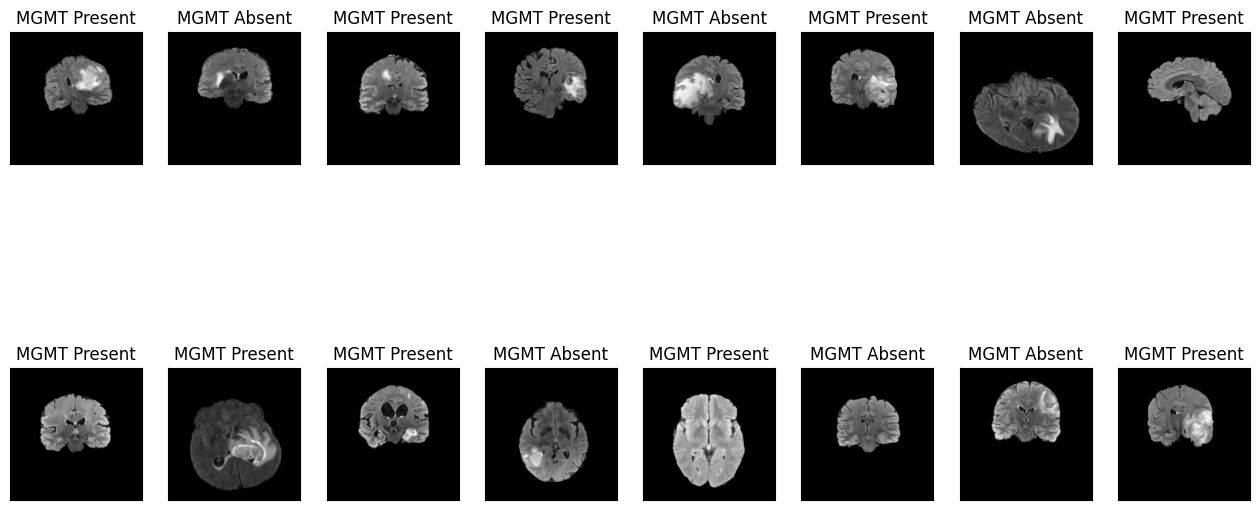

In [16]:
for batch in train_datasets[0].take(1):
    plt.figure(figsize=(16,8))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i])
        if batch[1][i] == 1:
            plt.title("MGMT Present")
        else:
            plt.title("MGMT Absent")
    plt.show()

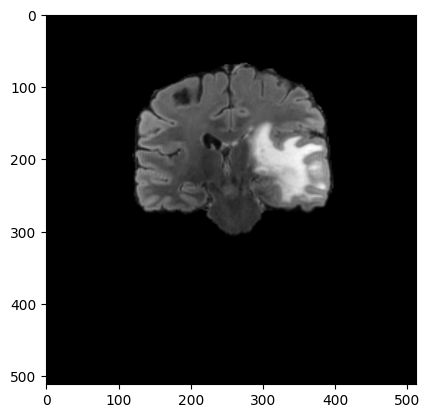

In [17]:
for image in test_datasets[0].take(1):
    plt.imshow(image[0])

In [18]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1, fill_mode="constant"),
    tf.keras.layers.RandomTranslation(height_factor=0.1,width_factor=0.1,fill_mode="constant")
])

In [19]:
def build_model():
    base = tf.keras.applications.Xception(      # Xception was changed to ResNet50 and EfficientNetB3 during training of the other two architectures
        include_top= False,
        weights = "/kaggle/input/tf-keras-pretrained-model-weights/No Top/xception_weights_tf_dim_ordering_tf_kernels_notop.h5",
        input_shape= (HEIGHT,WIDTH,3)
    )

    base.trainable = False

    inputs = tf.keras.Input(shape=(HEIGHT,WIDTH,3))
    x = data_augmentation(inputs)
    x = base(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, output)

    model.compile(
        loss= tf.keras.losses.BinaryCrossentropy(),
        optimizer= tf.keras.optimizers.Adam(1e-3),
        metrics= ["accuracy",AUC()]
    )
    
    return model

In [20]:
def train_model(model_name, train_ds, val_ds):
    
    print("==============================================================")
    print(f"training {model_name}")
    print("==============================================================")
    
    model = build_model()

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath= f"/kaggle/working/{model_name}_model.h5",
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_freq='epoch',
        verbose=1
    )

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1,
        restore_best_weights=True
    )

    reduce_lr_cb=ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5,
        patience=2,
        min_lr=0.00001,
        verbose=1
    )
    
    history = model.fit(
        train_ds,
        steps_per_epoch=len(train_ds),
        validation_data=val_ds,
        validation_steps=len(val_ds),
        epochs=EPOCHS,
        workers=2,
        callbacks=[checkpoint, reduce_lr_cb, early_stopping_cb]
    )
    
    return model

In [21]:
all_test_preds = []

for i, model_name in enumerate(['flair', 't1w', 't1wce', 't2w']):
    test_df = test[i]
    
    train_ds = train_datasets[i]
    val_ds = val_datasets[i]
    test_ds = test_datasets[i]
    
    best_model =  train_model(model_name, train_ds, val_ds)
    
    test_pred = best_model.predict(test_ds, steps=len(test_ds))
    test_df['pred_y'] = test_pred
    # aggregate the predictions on all image for each person (take the most confident prediction out of all image predictions)
    mean_pred = test_pred.mean()
    test_pred_agg = test_df.groupby('patient_ids').apply(
        lambda x: x['pred_y'].max()
        if (x['pred_y'].max() - mean_pred) > (mean_pred - x['pred_y'].min()) 
        else x['pred_y'].min())
    all_test_preds.append(test_pred_agg.values)

training flair
Epoch 1/20
82/82 [==============================] - ETA: 0s - loss: 0.7915 - accuracy: 0.5770 - auc: 0.5934
Epoch 1: val_loss improved from inf to 0.69238, saving model to /kaggle/working/flair_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


82/82 [==============================] - 80s 825ms/step - loss: 0.7915 - accuracy: 0.5770 - auc: 0.5934 - val_loss: 0.6924 - val_accuracy: 0.5125 - val_auc: 0.5090 - lr: 0.0010
Epoch 2/20
82/82 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.6195 - auc: 0.6480
Epoch 2: val_loss improved from 0.69238 to 0.67326, saving model to /kaggle/working/flair_model.h5
82/82 [==============================] - 61s 747ms/step - loss: 0.6964 - accuracy: 0.6195 - auc: 0.6480 - val_loss: 0.6733 - val_accuracy: 0.5556 - val_auc: 0.6088 - lr: 0.0010
Epoch 3/20
82/82 [==============================] - ETA: 0s - loss: 0.6398 - accuracy: 0.6486 - auc: 0.6945
Epoch 3: val_loss did not improve from 0.67326
82/82 [==============================] - 61s 741ms/step - loss: 0.6398 - accuracy: 0.6486 - auc: 0.6945 - val_loss: 0.6787 - val_accuracy: 0.5376 - val_auc: 0.5639 - lr: 0.0010
Epoch 4/20
82/82 [==============================] - ETA: 0s - loss: 0.6310 - accuracy: 0.6573 - auc: 0.7034

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


89/89 [==============================] - 73s 767ms/step - loss: 0.8015 - accuracy: 0.5636 - auc_1: 0.5863 - val_loss: 0.7261 - val_accuracy: 0.4708 - val_auc_1: 0.5264 - lr: 0.0010
Epoch 2/20
89/89 [==============================] - ETA: 0s - loss: 0.7115 - accuracy: 0.5952 - auc_1: 0.6308
Epoch 2: val_loss did not improve from 0.72613
89/89 [==============================] - 66s 742ms/step - loss: 0.7115 - accuracy: 0.5952 - auc_1: 0.6308 - val_loss: 0.7594 - val_accuracy: 0.4523 - val_auc_1: 0.4322 - lr: 0.0010
Epoch 3/20
89/89 [==============================] - ETA: 0s - loss: 0.6552 - accuracy: 0.6240 - auc_1: 0.6749
Epoch 3: val_loss did not improve from 0.72613

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
89/89 [==============================] - 66s 742ms/step - loss: 0.6552 - accuracy: 0.6240 - auc_1: 0.6749 - val_loss: 0.7615 - val_accuracy: 0.4400 - val_auc_1: 0.4625 - lr: 0.0010
Epoch 4/20
89/89 [==============================] - ETA: 0s - loss

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


108/108 [==============================] - 86s 754ms/step - loss: 0.8184 - accuracy: 0.5650 - auc_2: 0.5927 - val_loss: 0.7043 - val_accuracy: 0.4861 - val_auc_2: 0.4224 - lr: 0.0010
Epoch 2/20
108/108 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.6136 - auc_2: 0.6567
Epoch 2: val_loss did not improve from 0.70428
108/108 [==============================] - 80s 736ms/step - loss: 0.6927 - accuracy: 0.6136 - auc_2: 0.6567 - val_loss: 0.7083 - val_accuracy: 0.4675 - val_auc_2: 0.4560 - lr: 0.0010
Epoch 3/20
108/108 [==============================] - ETA: 0s - loss: 0.6433 - accuracy: 0.6481 - auc_2: 0.7006
Epoch 3: val_loss did not improve from 0.70428

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
108/108 [==============================] - 80s 736ms/step - loss: 0.6433 - accuracy: 0.6481 - auc_2: 0.7006 - val_loss: 0.7197 - val_accuracy: 0.4551 - val_auc_2: 0.4554 - lr: 0.0010
Epoch 4/20
108/108 [==============================] - ET

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


108/108 [==============================] - 90s 794ms/step - loss: 0.7932 - accuracy: 0.5691 - auc_3: 0.5799 - val_loss: 0.6662 - val_accuracy: 0.5843 - val_auc_3: 0.6218 - lr: 0.0010
Epoch 2/20
108/108 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.6250 - auc_3: 0.6386
Epoch 2: val_loss did not improve from 0.66621
108/108 [==============================] - 79s 732ms/step - loss: 0.6886 - accuracy: 0.6250 - auc_3: 0.6386 - val_loss: 0.6752 - val_accuracy: 0.5693 - val_auc_3: 0.5815 - lr: 0.0010
Epoch 3/20
108/108 [==============================] - ETA: 0s - loss: 0.6495 - accuracy: 0.6568 - auc_3: 0.6775
Epoch 3: val_loss did not improve from 0.66621

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
108/108 [==============================] - 79s 732ms/step - loss: 0.6495 - accuracy: 0.6568 - auc_3: 0.6775 - val_loss: 0.6720 - val_accuracy: 0.5730 - val_auc_3: 0.5888 - lr: 0.0010
Epoch 4/20
108/108 [==============================] - ET

In [22]:
all_test_preds = np.array(all_test_preds)

In [23]:
subm = pd.read_csv('/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')
subm['MGMT_value'] = all_test_preds.mean(0)
subm.to_csv("submission.csv", index=False)

In [24]:
subm

,BraTS21ID,MGMT_value
0,1,0.518641
1,13,0.482587
2,15,0.534938
3,27,0.550598
4,37,0.568040
...,...,...
82,826,0.466503
83,829,0.515454
84,833,0.524764
85,997,0.461521


Refernece:

- https://www.kaggle.com/code/cedricsoares/tf-efficientnet-transfer-learning-strat-split

### Thanks to @Cedric Soares
